# Hanganu et al. 2014

[A. Hanganu et al. “Mild cognitive impairment is linked with faster rate of cortical thinning in patients with Parkinson’s disease longitudinally” Brain, vol. 137, no. 4, pp. 1120–1129, 2014.](https://pubmed.ncbi.nlm.nih.gov/24613932/)

## Demographics

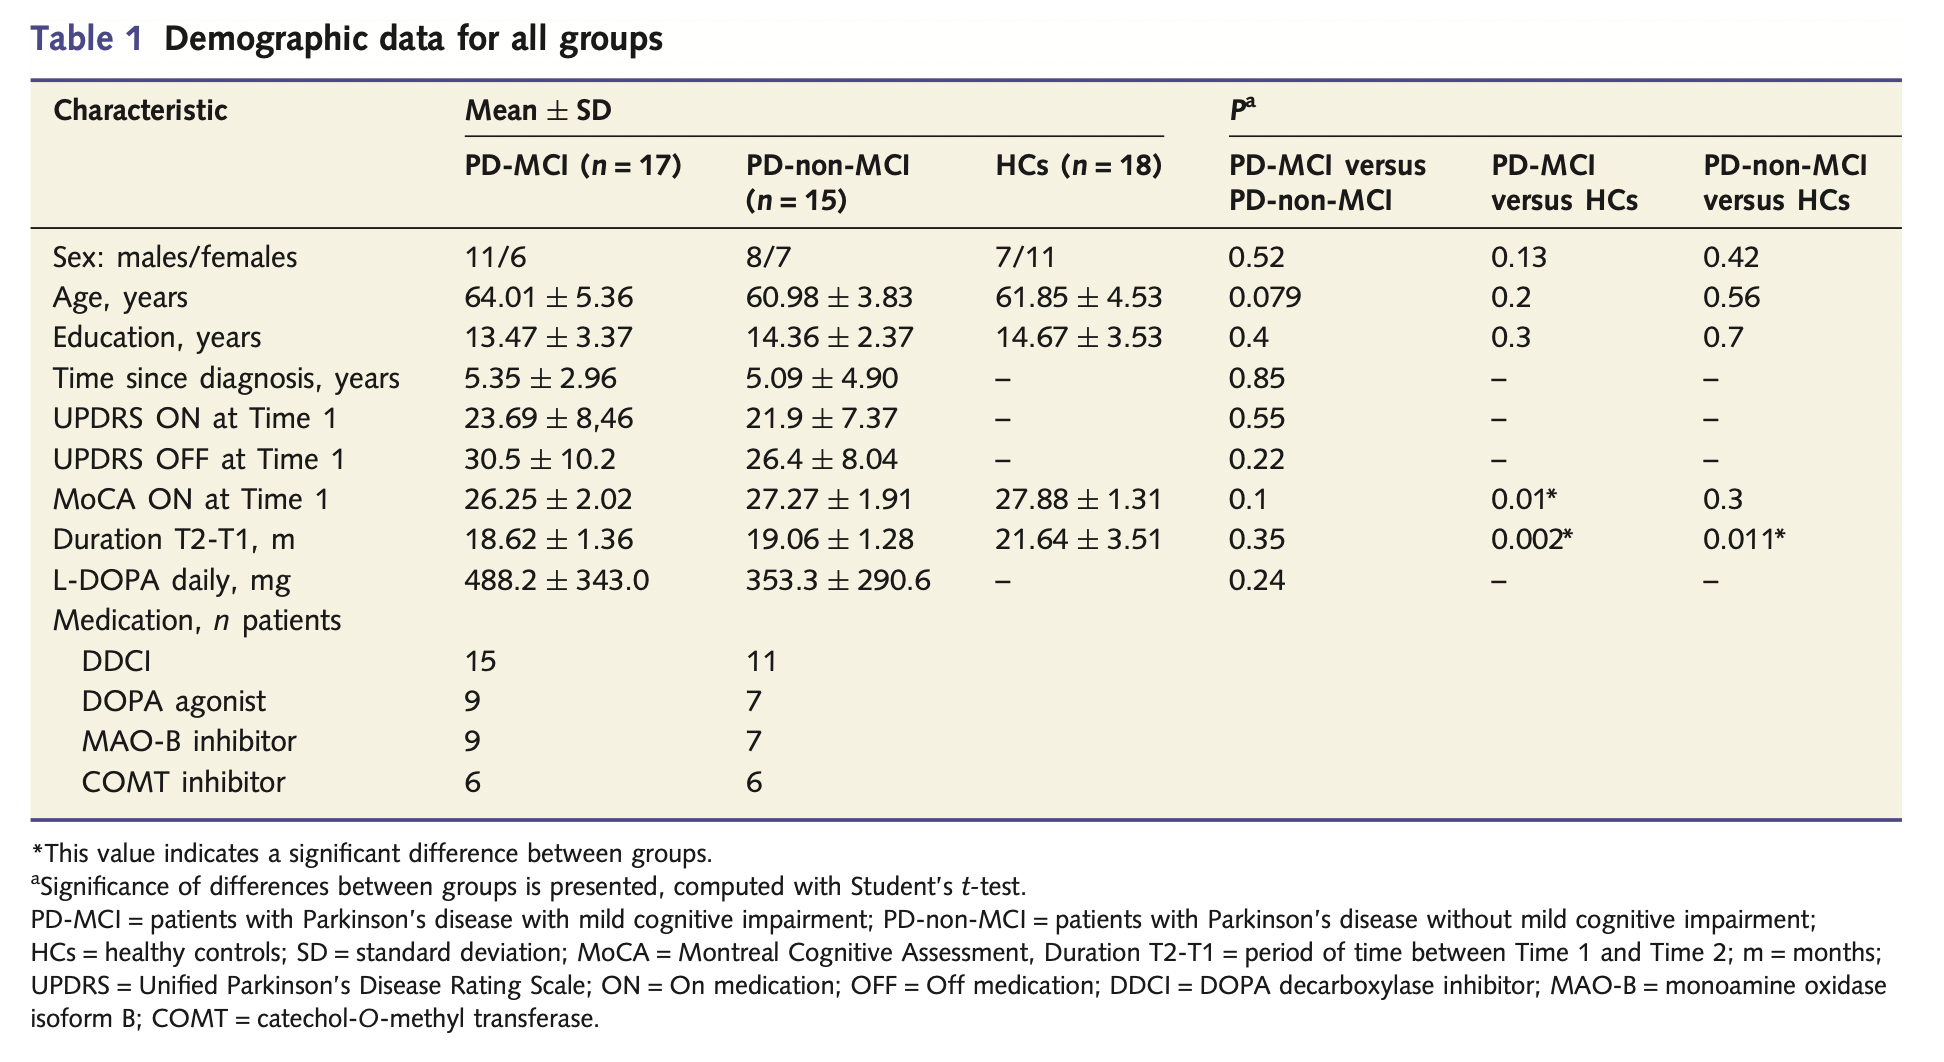

## Results

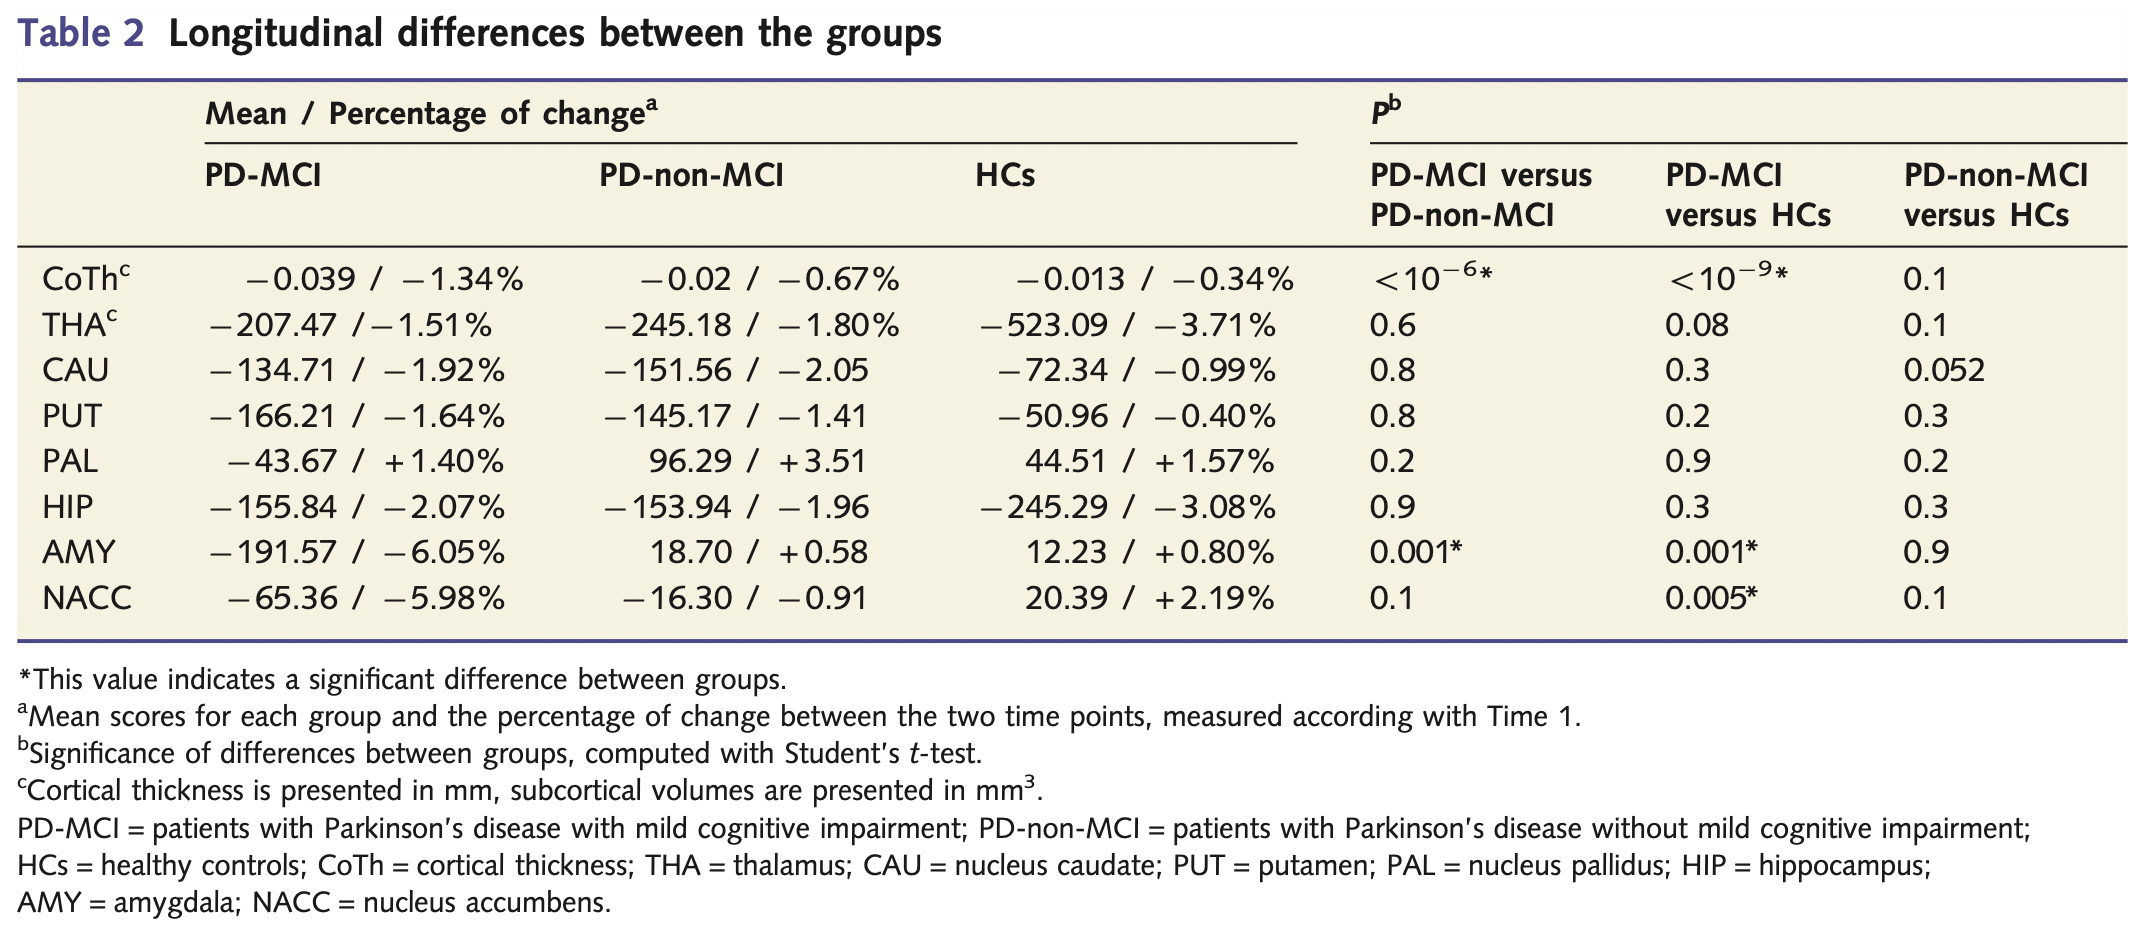

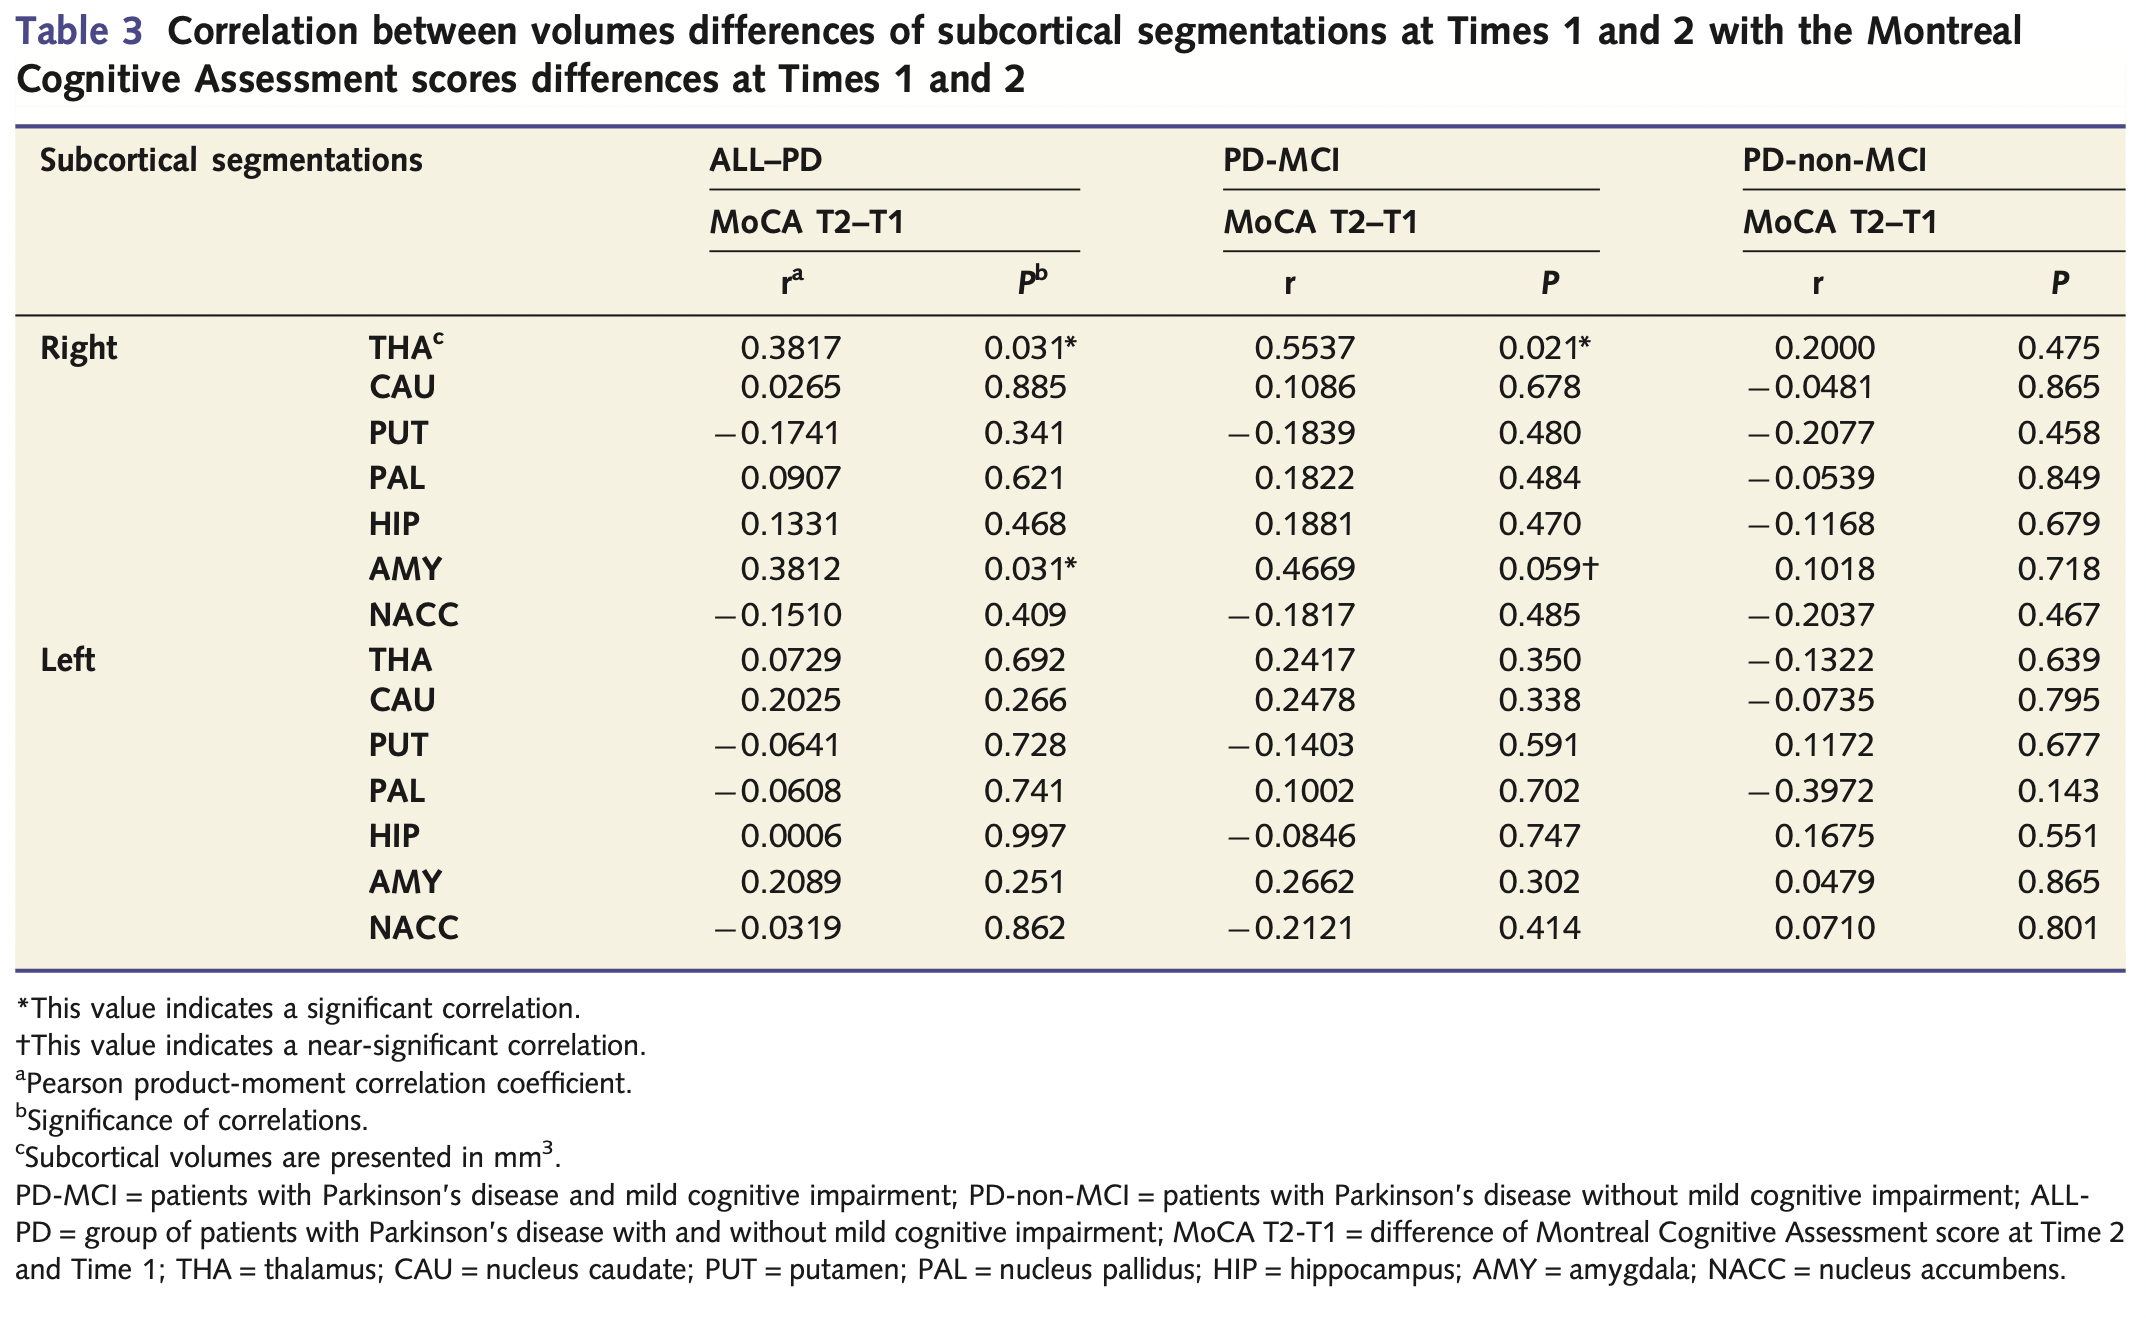

## Consistency

In [41]:
import pandas as pd
from pathlib import Path

anonymizer = True

root_dir = Path.cwd().parent.parent.parent.parent
# root_dir = Path.cwd() / "freesurfer-fuzzy"

def anondir(path: Path, prefix=root_dir) -> Path:
    """Anonymize a directory path by replacing user-specific parts with <root>."""
    if not anonymizer:
        return path
    path_str = str(path).replace(str(prefix), "<living-park>")
    return Path(path_str)


print(f"Running in root dir: {anondir(root_dir)}")
npv_dir = root_dir / "npv" / "csv_all"
assert npv_dir.exists(), f"{npv_dir} does not exist"
print(f"Using NPV dir: {anondir(npv_dir)}")
data_dir = root_dir / "notebooks" / "papers_data" / "parkinson" / "Hanganu_2014"
# data_dir = root_dir / "papers_data" / "parkinson" / "Hanganu_2014"
assert data_dir.exists(), f"{data_dir} does not exist"
print(f"Using data dir: {anondir(data_dir)}")

Running in root dir: <living-park>
Using NPV dir: <living-park>/npv/csv_all
Using data dir: <living-park>/notebooks/papers_data/parkinson/Hanganu_2014


### Load NPV maps

In [42]:
npv_thickness_long = pd.read_csv(
    npv_dir / "npv_hc-pd_thickness_bilateral_longitudinal.csv"
)
npv_subcortical_volume_bil_long = pd.read_csv(
    npv_dir / "npv_hc-pd_subcortical_volume_bilateral_longitudinal.csv"
)
npv_subcortical_volume_pd_long = pd.read_csv(
    npv_dir / "npv_pd_subcortical_volume_longitudinal.csv"
)

### Formula

In [43]:
import numpy as np
import scipy.stats


# T-test
def std_t(npv):
    return npv


def std_p_t(t, df, npv):
    return 2 * scipy.stats.t.pdf(np.abs(t), df) * npv


# Partial correlation
def std_r(r, n, npv):
    return np.sqrt((1 - r**2) ** 3 / (n - 1)) * npv


def std_p_r(r, n, npv):
    t = r * np.sqrt((n - 2) / (1 - r**2))
    return 2 * scipy.stats.t.pdf(np.abs(t), n - 2) * np.sqrt((n - 2) / (n - 1)) * npv

In [44]:
import pandas as pd
from scipy.stats import beta
import numpy as np


def beta_params_from_mean_var(mu, var, eps=1e-12):
    """Return (a,b) for Beta by moment matching. Clamps var to < mu(1-mu)."""
    max_var = mu * (1 - mu) - eps
    # Clamp var for non-degenerate cases
    var_clamped = np.minimum(var, max_var)

    # Calculate k for non-degenerate cases
    # Ensure we don't divide by zero if var_clamped becomes zero due to clamping
    # This can happen if mu*(1-mu) is very small and var is also very small but positive.
    # The original code implicitly handles this by setting k=1e6 when var<=0.
    # Here, we ensure that if var_clamped is effectively zero, k is large.
    # A small positive value for the denominator to avoid division by zero for k calculation
    denominator = np.where(var_clamped == 0, eps, var_clamped)
    k_calculated = mu * (1 - mu) / denominator - 1.0
    # Ensure k is not negative, as it should be > 0 for Beta distribution
    k_calculated = np.maximum(k_calculated, eps)  # k must be > 0

    a_calculated = mu * k_calculated
    b_calculated = (1 - mu) * k_calculated

    return a_calculated, b_calculated


def flip_proba_beta(p0, sigma_P, alpha=0.05):
    """
    Flip probability at alpha with P ~ Beta(a,b).
    Provide either sigma_P.
    Works with pandas Series/DataFrames.
    """
    var_P = sigma_P**2
    a, b = beta_params_from_mean_var(p0, var_P)

    # Determine the flip probability based on p0 relative to alpha
    # Use np.where for vectorized conditional logic
    # pflip_non_significant = 1.0 - beta.cdf(alpha, a, b) # if p0 < alpha, flip if P > alpha
    pflip_significant = beta.cdf(alpha, a, b)  # if p0 >= alpha, flip if P <= alpha

    # pflip = np.where(p0 < alpha, pflip_significant, pflip_non_significant)
    pflip = pflip_significant

    # Clip the result to ensure it's within [0, 1]
    return np.clip(pflip, 0.0, 1.0)

In [45]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd


def plot_dumbbell(results, title, group=None):
    columns = [
        "region",
        "p_value",
        "npv",
        "std_p",
        "std_p_low",
        "std_p_high",
        "proba_significant",
    ]
    columns = columns + [group] if group else columns
    df = results.copy()
    df = df[columns]
    df.rename(
        columns={
            "std_p": "std_p",
            "std_r": "std_r",
            "sig": "sig",
            "p": "p_value",
            "std_p_low": "std_p_low",
            "std_p_high": "std_p_high",
            "proba_significant": "psig",
        },
        inplace=True,
    )
    df["std_p_low"] = df["std_p"] - df["std_p_low"]
    df["std_p_high"] = df["std_p_high"] - df["std_p"]

    col_label = "std_p"

    fig = make_subplots(
        rows=1,
        cols=3,
        subplot_titles=["p-value", "std p-value", "Probability significance"],
    )

    fig_1 = px.scatter(df, x="region", y="p_value", color=group)
    # Add lines for each dumbbell
    fig_2 = px.scatter(
        df,
        x="region",
        y="std_p",
        color=group,
        error_y="std_p_low",
        error_y_minus="std_p_high",
        labels="std_p",
    )
    fig_3 = go.Scatter(
        x=df["region"],
        y=df["psig"],
        mode="markers",
        marker_color="black",
        marker_symbol="cross",
        name="Flip probability",
        showlegend=False,
    )

    fig.add_traces(fig_1.data, rows=1, cols=1)
    fig.add_traces(fig_2.data, rows=1, cols=2)
    fig.add_traces(fig_3, rows=1, cols=3)

    fig.update_layout(
        title=title,
        yaxis_title=col_label,
        xaxis_title="Value",
        hovermode="closest",
        height=600,
        width=1400,
    )

    fig.add_hline(y=0.05, line_color="red", line_width=2, row=1, col=1)
    fig.update_yaxes(range=[-0.05, 1.05])

    return fig

### Table 2 - Longitudinal differences between the groups

No uncertainty can be estimated for this table since $t$ values are not reported.

### Table 3 - Correlation between change of cortical thickness and MoCA

In [46]:
df = pd.read_csv(data_dir / "table_3.csv")
df["region"] = df["hemisphere"] + "-" + df["region"]
df = pd.merge(df, npv_subcortical_volume_pd_long, on="region")

n_pd_mci = 17
n_pd_non_mci = 15
n_pd_all = n_pd_mci + n_pd_non_mci
n_hc = 18

# Sample sizes
df["ALL_PD_sample_size"] = n_pd_all
df["PD_MCI_sample_size"] = n_pd_mci
df["PD_non_MCI_sample_size"] = n_pd_non_mci

# Std r coefficients
df["ALL_PD_std_r"] = std_r(df["ALL_PD_r"], n_pd_all, df["npv"])
df["PD_MCI_std_r"] = std_r(df["PD_MCI_r"], n_pd_mci, df["npv"])
df["PD_non_MCI_std_r"] = std_r(df["PD_non_MCI_r"], n_pd_non_mci, df["npv"])

# Std p-values
df["ALL_PD_std_p"] = std_p_r(df["ALL_PD_r"], n_pd_all, df["npv"])
df["ALL_PD_std_p_low"] = std_p_r(df["ALL_PD_r"], n_pd_all, df["npv_CI_low"])
df["ALL_PD_std_p_high"] = std_p_r(df["ALL_PD_r"], n_pd_all, df["npv_CI_high"])
df["ALL_PD_proba_significant"] = flip_proba_beta(df["ALL_PD_p"], df["ALL_PD_std_p"])
df["ALL_PD_significant"] = df["ALL_PD_sig"] == "*"
df_all_pd = df[
    [
        "region",
        "ALL_PD_sample_size",
        "ALL_PD_std_r",
        "ALL_PD_p",
        "ALL_PD_std_p",
        "ALL_PD_std_p_low",
        "ALL_PD_std_p_high",
        "ALL_PD_proba_significant",
        "ALL_PD_significant",
        "npv"
    ]
].copy()
df_all_pd.columns = [
    "region",
    "sample_size",
    "std_r",
    "p_value",
    "std_p",
    "std_p_low",
    "std_p_high",
    "proba_significant",
    "significant",
    "npv"
]
df_all_pd["group"] = "ALL_PD"

df["PD_MCI_std_p"] = std_p_r(df["PD_MCI_r"], n_pd_mci, df["npv"])
df["PD_MCI_std_p_low"] = std_p_r(df["PD_MCI_r"], n_pd_mci, df["npv_CI_low"])
df["PD_MCI_std_p_high"] = std_p_r(df["PD_MCI_r"], n_pd_mci, df["npv_CI_high"])
df["PD_MCI_proba_significant"] = flip_proba_beta(df["PD_MCI_p"], df["PD_MCI_std_p"])
df["PD_MCI_significant"] = df["PD_MCI_sig"] == "*"
df_pd_mci = df[
    [
        "region",
        "PD_MCI_sample_size",
        "PD_MCI_std_r",
        "PD_MCI_p",
        "PD_MCI_std_p",
        "PD_MCI_std_p_low",
        "PD_MCI_std_p_high",
        "PD_MCI_proba_significant",
        "PD_MCI_significant",
        "npv"
    ]
].copy()
df_pd_mci.columns = [
    "region",
    "sample_size",
    "std_r",
    "p_value",
    "std_p",
    "std_p_low",
    "std_p_high",
    "proba_significant",
    "significant",
    "npv"
]
df_pd_mci["group"] = "PD_MCI"


df["PD_non_MCI_std_p"] = std_p_r(df["PD_non_MCI_r"], n_pd_non_mci, df["npv"])
df["PD_non_MCI_std_p_low"] = std_p_r(df["PD_non_MCI_r"], n_pd_non_mci, df["npv_CI_low"])
df["PD_non_MCI_std_p_high"] = std_p_r(df["PD_non_MCI_r"], n_pd_non_mci, df["npv_CI_high"])
df["PD_non_MCI_proba_significant"] = flip_proba_beta(
    df["PD_non_MCI_p"], df["PD_non_MCI_std_p"]
)
df["PD_non_MCI_significant"] = df["PD_non_MCI_sig"] == "*"
df_pd_non_mci = df[
    [
        "region",
        "PD_non_MCI_sample_size",
        "PD_non_MCI_std_r",
        "PD_non_MCI_p",
        "PD_non_MCI_std_p",
        "PD_non_MCI_std_p_low",
        "PD_non_MCI_std_p_high",
        "PD_non_MCI_proba_significant",
        "PD_non_MCI_significant",
        "npv"
    ]
].copy()
df_pd_non_mci.columns = [
    "region",
    "sample_size",
    "std_r",
    "p_value",
    "std_p",
    "std_p_low",
    "std_p_high",
    "proba_significant",
    "significant",
    "npv"
]
df_pd_non_mci["group"] = "PD_non_MCI"

df = pd.concat([df_all_pd, df_pd_mci, df_pd_non_mci], ignore_index=True)
df["metric"] = "subcortical volume"
df["alpha"] = 0.05
df["test"] = "R"

In [47]:
plot_dumbbell(df, "", "group")

In [48]:
# Assert dataframe contains "proba_significant" and "significant" columns
df["study"] = "longitudinal"
assert "p_value" in df.columns
assert "proba_significant" in df.columns
assert "significant" in df.columns
assert "sample_size" in df.columns
assert "test" in df.columns
assert "metric" in df.columns
assert "study" in df.columns
df.to_csv(data_dir / "uncertainty.csv", index=False)